In [0]:
!pip install stop_words

In [0]:
from google.colab import drive
import glob
import pandas as pd
import re
import keras
#from stop_words import get_stop_words
#from nltk.tokenize import RegexpTokenizer
import numpy as np
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Flatten, Dropout, Conv1D, MaxPooling1D, Activation
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
folders = ["train","validation","test"]
keys = ["exercise","target"]
classes = ["3D geometric figures in spatial diagrams","arithmetic","crypto-arithmetic","geometric figures in spatial diagrams OR puzzle","numbers in spatial diagrams","spatial reasoning","temporal reasoning"]


In [33]:
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [34]:
file_path = glob.glob("/gdrive/My Drive/Colab Notebooks/progetto/code/dataset/***.csv")
print(file_path)
i=0
data={}
for file in file_path:
  data[folders[i]]=pd.read_csv(file)
  i=i+1

['/gdrive/My Drive/Colab Notebooks/progetto/code/dataset/test.csv', '/gdrive/My Drive/Colab Notebooks/progetto/code/dataset/validation.csv', '/gdrive/My Drive/Colab Notebooks/progetto/code/dataset/train.csv']


In [0]:
#total_words=[]

In [0]:
def set_vocabulary(sen):
  for w in sen:
    if w not in total_words:
      total_words.append(w)

In [0]:
def remove_stopwords(sen):
  words = [w for w in sen if w not in get_stop_words('italian')]
  return words

In [0]:
def preprocess_text(sen):

  sentence = sen.apply((lambda x: re.sub('[^a-zA-Z]', ' ', x)))             # Remove punctuations and numbers
  sentence = sentence.apply((lambda x: re.sub('[\s+[a-zA-Z]\s+]', ' ', x))) # Single character removal
  sentence = sentence.apply((lambda x: re.sub('\s+', ' ', x))) # Removing multiple spaces

  sentence = sentence.apply(lambda x: x.lower())                            # to lowercase

  #sentence = sentence.apply(lambda x: tokenizer.tokenize(x))

  #sentence = sentence.apply(lambda x: remove_stopwords(x))
  #sentence.apply(lambda x: set_vocabulary(x))
  #print(len(total_words))
  return sentence



In [0]:
print(data[folders[1]][keys[0]])

In [0]:
for folder in folders:
  data[folder][keys[0]] = preprocess_text(data[folder][keys[0]]) 

In [0]:
print(data[folders[1]][keys[0]])

In [0]:
embed_dim = 300

X_train = data[folders[0]][keys[0]]
Y_train = pd.get_dummies(data[folders[0]][keys[1]]).values

X_validation = data[folders[1]][keys[0]]
Y_validation = pd.get_dummies(data[folders[1]][keys[1]]).values

X_test = data[folders[2]][keys[0]]
Y_test = pd.get_dummies(data[folders[2]][keys[1]]).values

In [0]:
MAX_SEQUENCE_LENGTH = 200
tokenizer = Tokenizer(num_words=5000, split=' ')

text = np.concatenate((X_train, X_validation, X_test), axis=0)
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text)
vocab_size = len(tokenizer.word_index)
text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

X_train = text[0:len(X_train), ]
X_validation = text[len(X_train):len(X_train)+len(X_validation), ]
X_test = text[len(X_train)+len(X_validation):, ]

print('train')
print(X_train)
print(Y_train)

print('validation')
print(X_validation)
print(Y_validation)

print('test')
print(X_test)
print(Y_test)

In [0]:
#vocab_size = 5000 # number of different words, we have 27 different words so we can set anumber greater or equal to 27
maxlen = 100
tokenizer = Tokenizer(num_words=5000, split=' ')

tokenizer.fit_on_texts(data[folders[0]][keys[0]].values)
X_train = tokenizer.texts_to_sequences(data[folders[0]][keys[0]].values)
X_train = pad_sequences(X_train, maxlen=maxlen, padding='post', truncating='post')
Y_train = pd.get_dummies(data[folders[0]][keys[1]]).values

print('train')
print(X_train)
print(Y_train)

# same for validation data
tokenizer.fit_on_texts(data[folders[1]][keys[0]].values)
X_validation = tokenizer.texts_to_sequences(data[folders[1]][keys[0]].values)
X_validation = pad_sequences(X_validation, maxlen=maxlen, padding='post', truncating='post')
Y_validation = pd.get_dummies(data[folders[1]][keys[1]]).values

print('validation')
print(X_validation)
print(Y_validation)

# same for test data
tokenizer.fit_on_texts(data[folders[2]][keys[0]].values)
X_test = tokenizer.texts_to_sequences(data[folders[2]][keys[0]].values)
X_test = pad_sequences(X_test, maxlen=maxlen, padding='post', truncating='post')
Y_test = pd.get_dummies(data[folders[2]][keys[1]]).values

print('test')
print(X_test)
print(Y_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

In [43]:
#vocab_size = len(total_words)
embed_dim = 300 # size of Word2Vec embeddings
lstm_out = 5
vocab_size

4645

In [0]:
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

In [45]:
from gensim.models import KeyedVectors
#from gensim.test.utils import common_texts
m = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)
#m = Word2Vec(common_texts, size=300, window=5, min_count=1, workers=4)
#m = Word2Vec.load(EMBEDDING_FILE)
#x = word2vec.word_vec("numero")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
m.wv["ciao"]

In [0]:
embedding_matrix = np.zeros((vocab_size, embed_dim))

In [0]:
for word, i in tokenizer.word_index.items():
  if word in m.wv:
    print(word)
    embedding_matrix[i] = m.wv[word] # we take here only the embedding of the words we have in our vocabulary

In [0]:
print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)

(177, 200)
(70, 200)
(483, 200)


In [0]:
embedding_matrix.shape

(4645, 300)

In [0]:
print(X_train[0])
print(X_validation[0])
print(X_test[0])

In [0]:
model = Sequential()
model.add(Embedding(vocab_size, embed_dim, weights=[embedding_matrix],input_length=X_train.shape[1], trainable=False))
# this option must be used if we have more LSTM
model.add(Bidirectional(LSTM(lstm_out, return_sequences=True, activation='tanh', dropout=0.5, recurrent_dropout=0.2)))
model.add(Bidirectional(LSTM(lstm_out, return_sequences=True, activation='tanh', dropout=0.5, recurrent_dropout=0.2)))
model.add(Bidirectional(LSTM(lstm_out, return_sequences=True, activation='tanh', dropout=0.5, recurrent_dropout=0.2)))
model.add(LSTM(lstm_out, return_sequences=True))
model.add(LSTM(lstm_out))
model.add(Dense(len(classes), activation='softmax'))

In [0]:
model.summary()

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [0]:
history = model.fit(X_train, Y_train, epochs=50, batch_size=100,validation_data=(X_validation, Y_validation), verbose=2, shuffle=True)

In [0]:
import matplotlib.pyplot as plt
#plt.style.use('ggplot')
plt.style.use('seaborn-bright')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

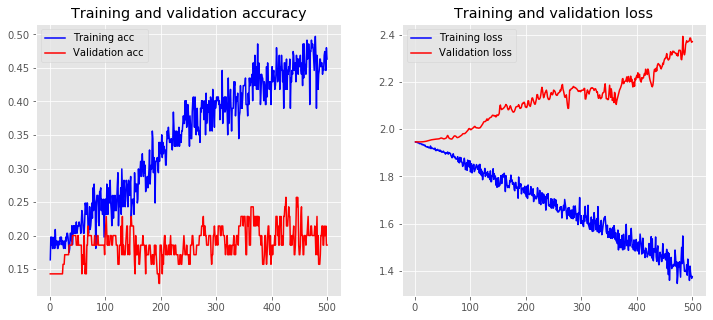

In [0]:
plot_history(history)

In [0]:
model.predict(X_test)

array([[0.03393471, 0.30428672, 0.11708576, ..., 0.14341967, 0.02308743,
        0.26594323],
       [0.02490724, 0.46723753, 0.00451836, ..., 0.02450627, 0.0055573 ,
        0.1324012 ],
       [0.05374283, 0.13998069, 0.31676042, ..., 0.20917216, 0.04777954,
        0.16803873],
       ...,
       [0.09507746, 0.06016356, 0.42778614, ..., 0.17067394, 0.10189436,
        0.10315286],
       [0.17268798, 0.01904153, 0.12287967, ..., 0.08040285, 0.5420361 ,
        0.04016729],
       [0.05142854, 0.15218265, 0.29574275, ..., 0.20870821, 0.04505534,
        0.1791137 ]], dtype=float32)

In [0]:
model.evaluate(X_train, Y_train)

177/177 [==============================] - 0s 3ms/step


[1.259766263476873, 0.5084745774498094]

In [0]:
def Build_Model_RCNN_Text(vocab_size=5000, nclasses=7, MAX_SEQUENCE_LENGTH=500, embed_dim=5,embedding_matrix=np.zeros((4000, 5))):
    kernel_size = 2
    filters = 256
    pool_size = 2
    gru_node = 256
    
    model = Sequential()
    model.add(Embedding(vocab_size, embed_dim, weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    #model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM,weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,trainable=True))
    model.add(Dropout(0.25))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2))
    model.add(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2))
    model.add(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2))
    model.add(LSTM(gru_node, recurrent_dropout=0.2))
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dense(nclasses))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model


In [0]:
X_validation.shape[1]

100

In [0]:
model_RCNN = Build_Model_RCNN_Text(vocab_size=vocab_size, nclasses=len(classes), MAX_SEQUENCE_LENGTH=X_train.shape[1], embed_dim=embed_dim, embedding_matrix=embedding_matrix)

In [0]:
model_RCNN.summary()

In [0]:
history_RCNN = model_RCNN.fit(X_train, Y_train, epochs=200, batch_size=32,validation_data=(X_validation, Y_validation), verbose=2, shuffle=True)

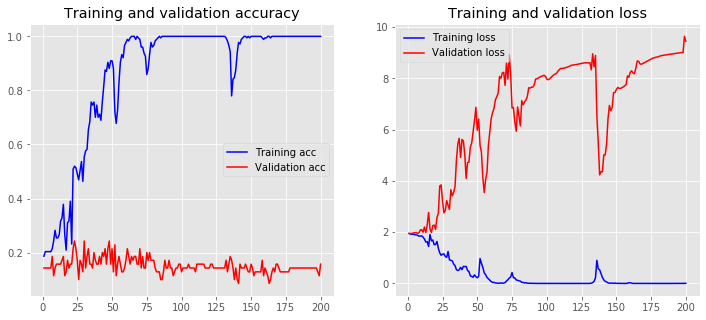

In [0]:
plot_history(history)

In [0]:
model_RCNN.evaluate(X_validation, Y_validation)

70/70 [==============================] - 0s 2ms/step


[4.645621640341623, 0.4285714294229235]

In [0]:
def Build_Model_RCNN_drop_Text(vocab_size=5000, nclasses=7, MAX_SEQUENCE_LENGTH=500, embed_dim=5,embedding_matrix=np.zeros((4000, 5))):
    kernel_size = 2
    filters = 256
    pool_size = 2
    gru_node = 256
    
    model = Sequential()
    model.add(Embedding(vocab_size, embed_dim, weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    model.add(Dropout(0.25))

    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling1D(pool_size=pool_size))

    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling1D(pool_size=pool_size))

    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling1D(pool_size=pool_size))

    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling1D(pool_size=pool_size))

    model.add(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2))
    model.add(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2))
    model.add(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2))
    model.add(LSTM(gru_node, recurrent_dropout=0.2))
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dense(nclasses))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model


In [0]:
model_RCNN_drop = Build_Model_RCNN_drop_Text(vocab_size=vocab_size, nclasses=len(classes), MAX_SEQUENCE_LENGTH=X_train.shape[1], embed_dim=embed_dim, embedding_matrix=embedding_matrix)

In [0]:
history_RCNN_drop = model_RCNN_drop.fit(X_train, Y_train, epochs=200, batch_size=32,validation_data=(X_validation, Y_validation), verbose=2, shuffle=True)

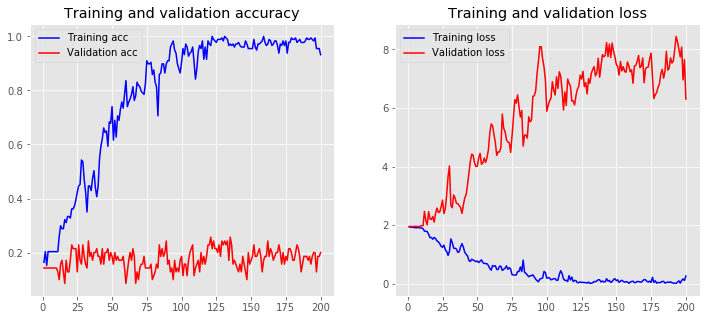

In [0]:
plot_history(history_RCNN_drop)

In [0]:
def Build_Model_RCNN_drop_sgd_Text(vocab_size=5000, nclasses=7, MAX_SEQUENCE_LENGTH=500, embed_dim=5,embedding_matrix=np.zeros((4000, 5))):
    kernel_size = 2
    filters = 256
    pool_size = 2
    gru_node = 256
    
    model = Sequential()
    model.add(Embedding(vocab_size, embed_dim, weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    model.add(Dropout(0.25))

    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling1D(pool_size=pool_size))

    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling1D(pool_size=pool_size))

    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling1D(pool_size=pool_size))

    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling1D(pool_size=pool_size))

    model.add(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2))
    model.add(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2))
    model.add(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2))
    model.add(LSTM(gru_node, recurrent_dropout=0.2))
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dense(nclasses))
    model.add(Activation('softmax'))
    '''
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    '''
    # initiate RMSprop optimizer
    opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
    #sgd = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    sgd = keras.optimizers.SGD(lr=0.001, momentum=0.9)
    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
    return model


In [0]:
model_RCNN_drop_sgd = Build_Model_RCNN_drop_sgd_Text(vocab_size=vocab_size, nclasses=len(classes), MAX_SEQUENCE_LENGTH=X_train.shape[1], embed_dim=embed_dim, embedding_matrix=embedding_matrix)

In [0]:
history_RCNN_drop_sgd = model_RCNN_drop_sgd.fit(X_train, Y_train, epochs=200, batch_size=32,validation_data=(X_validation, Y_validation), verbose=2, shuffle=True)

Train on 177 samples, validate on 70 samples
Epoch 1/200
 - 16s - loss: 1.9437 - acc: 0.1864 - val_loss: 1.9453 - val_acc: 0.1429
Epoch 2/200
 - 2s - loss: 1.9327 - acc: 0.2034 - val_loss: 1.9453 - val_acc: 0.1429
Epoch 3/200
 - 2s - loss: 1.9156 - acc: 0.2034 - val_loss: 1.9514 - val_acc: 0.1429
Epoch 4/200
 - 2s - loss: 1.9149 - acc: 0.2034 - val_loss: 1.9481 - val_acc: 0.1429
Epoch 5/200
 - 2s - loss: 1.9100 - acc: 0.2034 - val_loss: 1.9500 - val_acc: 0.1429
Epoch 6/200
 - 2s - loss: 1.9116 - acc: 0.2034 - val_loss: 1.9496 - val_acc: 0.1429
Epoch 7/200
 - 2s - loss: 1.9103 - acc: 0.2034 - val_loss: 1.9505 - val_acc: 0.1429
Epoch 8/200
 - 2s - loss: 1.9090 - acc: 0.2034 - val_loss: 1.9478 - val_acc: 0.1429
Epoch 9/200
 - 2s - loss: 1.9086 - acc: 0.2034 - val_loss: 1.9458 - val_acc: 0.1429
Epoch 10/200
 - 2s - loss: 1.9091 - acc: 0.2034 - val_loss: 1.9470 - val_acc: 0.1429
Epoch 11/200
 - 2s - loss: 1.9067 - acc: 0.2034 - val_loss: 1.9471 - val_acc: 0.1429
Epoch 12/200
 - 2s - loss: 1

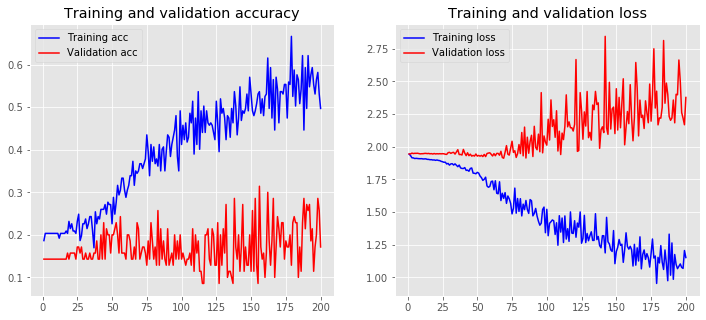

In [0]:
plot_history(history_RCNN_drop_sgd)